In [1]:
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import math




import ThinLens.Elements as Elements
import ThinLens.Maps as Maps
from ThinLens.Models import  SIS18_Lattice_minimal_sa, F0D0Model_single, F0D0Model6, F0D0Model12

sys.path.append("../")


import matplotlib.pyplot as plt
import numpy as np

import cpymad.madx

from ThinLens.Beam import Beam
import tools.plot

import json

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# visualize difference in multipole components


def plot_multipole(initialDiffNormal, finalDiffNormal=None):
    multipoleFig, multipoleAxes = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    multipoleFig.suptitle("multipole strengths")


    for i in range(len(multipoleAxes)):
        for j in range(len(multipoleAxes[i])):
            multipoleAxes[i, j].ticklabel_format(style="sci", scilimits=(0,0))

    multipoleAxes[0, 0].plot(model.positions, abs(initialDiffNormal[0]))
    multipoleAxes[0, 1].plot(model.positions, initialDiffNormal[1])
    
    bottom_1, top_1 = multipoleAxes[0, 0].get_ylim()
    bottom_2, top_2 = multipoleAxes[0, 1].get_ylim()
    
    if not (finalDiffNormal is None):
        multipoleAxes[1, 0].plot(model.positions, abs(finalDiffNormal[0]))
        multipoleAxes[1, 1].plot(model.positions, finalDiffNormal[1])
        
        #multipoleAxes[1, 0].set_ylim(bottom_1, top_1)
        #multipoleAxes[1, 1].set_ylim(bottom_2, top_2)

    multipoleAxes[0, 0].set_title("k1n")
    multipoleAxes[0, 1].set_title("k2n")
    multipoleAxes[0, 0].set_ylabel("initial")
    multipoleAxes[1, 0].set_ylabel("after training")

    multipoleAxes[1, 0].set_xlabel("pos / m")
    multipoleAxes[1, 1].set_xlabel("pos / m")
    
    #multipoleAxes[0, 0].set_yscale('log')
    #multipoleAxes[1, 0].set_yscale('log')
    #multipoleAxes[0, 1].set_yscale('log')
    #multipoleAxes[1, 1].set_yscale('log')
    
    return multipoleFig
    
def plot_trajectories(initialTrajectoriesDifference, finalTrajectoriesDifference=None):
    # plot initial trajectories
    figTrajectories, axesTrajectories = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    figTrajectories.suptitle("trajectories")

    for i in range(len(axesTrajectories)):
        for j in range(len(axesTrajectories[i])):
            axesTrajectories[i, j].ticklabel_format(style="sci", scilimits=(0,0))

    #initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)

    tools.plot.trajectories(axesTrajectories[0, 0], initialTrajectoriesDifference, model, plane="x")
    tools.plot.trajectories(axesTrajectories[0, 1], initialTrajectoriesDifference, model, plane="y")
    
    bottom_x, top_x = axesTrajectories[0, 0].get_ylim()
    bottom_y, top_y = axesTrajectories[0, 1].get_ylim()
        
    
    if not (finalTrajectoriesDifference is None):
        tools.plot.trajectories(axesTrajectories[1, 0], finalTrajectoriesDifference, model, plane="x")
        tools.plot.trajectories(axesTrajectories[1, 1], finalTrajectoriesDifference, model, plane="x")
        
        axesTrajectories[1, 0].set_ylim(bottom_x, top_x)
        axesTrajectories[1, 1].set_ylim(bottom_y, top_y)


    axesTrajectories[0, 0].set_ylabel("initial diff.")
    axesTrajectories[1, 0].set_ylabel("after training")
    axesTrajectories[1, 0].set_xlabel("hor. pos / m")
    axesTrajectories[1, 1].set_xlabel("ver. pos / m")
    
    return figTrajectories

    
def plot_beta(modelTwiss, perturbedTwiss, finalModelTwiss=None):

    # plot inital beta
    #modelTwiss, perturbedTwiss = model.getTwiss(), perturbedModel.getTwiss()
    
    #finalModelTwiss = model.getTwiss()


    figBeta, axesBeta = plt.subplots(2, sharex=True)
    figBeta.suptitle("beta-function")
    try:
        axesBeta[0].plot(modelTwiss["s"], modelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
        axesBeta[0].plot(modelTwiss["s"], modelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
        bottom, top = axesBeta[0].get_ylim()

        if not (finalModelTwiss is None):
            axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
            axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
            #axesBeta[1].set_ylim(bottom, top)

    except ThinLens.Models.TwissFailed as e:
        print(e)
        print("warning twiss failed")

    axesBeta[0].set_ylabel("initial diff. / m")
    axesBeta[1].set_ylabel("final diff. / m")
    
    axesBeta[0].legend()
    #axesBeta[1].legend()
    
    return figBeta


def plot_Twiss_perturbedModel(modelTwiss, perturbedTwiss):
    figBeta2, axesBeta2 = plt.subplots(2, sharex=True)
    figBeta2.suptitle("beta-function")
    try:
        axesBeta2[0].plot(modelTwiss["s"], perturbedTwiss["betx"], label="hor.")
        axesBeta2[1].plot(modelTwiss["s"], perturbedTwiss["bety"], label="ver.")
    except ThinLens.Models.TwissFailed as e:
        print(e)
        print("warning twiss failed")
    axesBeta[0].set_ylabel("betx / m")
    axesBeta[1].set_ylabel("bety / m")

In [3]:
def plot_trajectories(initialTrajectoriesDifference, finalTrajectoriesDifference=None):
    # plot initial trajectories
    figTrajectories, axesTrajectories = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    figTrajectories.suptitle("trajectories")

    for i in range(len(axesTrajectories)):
        for j in range(len(axesTrajectories[i])):
            axesTrajectories[i, j].ticklabel_format(style="sci", scilimits=(0,0))

    #initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)

    tools.plot.trajectories(axesTrajectories[0, 0], initialTrajectoriesDifference, model, plane="x")
    tools.plot.trajectories(axesTrajectories[0, 1], initialTrajectoriesDifference, model, plane="y")
    
    bottom_x, top_x = axesTrajectories[0, 0].get_ylim()
    bottom_y, top_y = axesTrajectories[0, 1].get_ylim()
        
    
    if not (finalTrajectoriesDifference is None):
        tools.plot.trajectories(axesTrajectories[1, 0], finalTrajectoriesDifference, model, plane="x")
        tools.plot.trajectories(axesTrajectories[1, 1], finalTrajectoriesDifference, model, plane="y")
        
        #axesTrajectories[1, 0].set_ylim(bottom_x, top_x)
        #axesTrajectories[1, 1].set_ylim(bottom_y, top_y)

    axesTrajectories[0, 0].set_title('Hor. trajectories difference')
    axesTrajectories[0, 1].set_title('Ver. trajectories difference')

    axesTrajectories[0, 0].set_ylabel("initial diff.")
    axesTrajectories[1, 0].set_ylabel("after training")
    axesTrajectories[1, 0].set_xlabel("hor. pos / m")
    axesTrajectories[1, 1].set_xlabel("ver. pos / m")
    
    return figTrajectories


In [4]:
# visualize difference in multipole components
def compareMultipoleStrengths(modelA, modelB):
    diff_k1n, diff_k2n = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))
    diff_k1s, diff_k2s = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))

    for i in range(len(modelA.elements)):
        if type(modelA.elements[i]) is Elements.Quadrupole:#Tripplet:
            diff_k1n[i] = modelA.elements[i].k1n.item() - modelB.elements[i].k1n.item()
            diff_k1s[i] = modelA.elements[i].k1s.item() - modelB.elements[i].k1s.item()
            diff_k2n[i] = modelA.elements[i].k2n.item() - modelB.elements[i].k2n.item()
            diff_k2s[i] = modelA.elements[i].k2s.item() - modelB.elements[i].k2s.item()
        else:
            diff_k1n[i] = 0
            diff_k1s[i] = 0
            diff_k2n[i] = 0
            diff_k2s[i] = 0

    return tuple([(diff_k1n, diff_k2n), (diff_k1s, diff_k2s),])


In [5]:
# general
# torch.set_printoptions(precision=4, sci_mode=False)

dim = 6
slices = 4
quadSliceMultiplicity = 1
dtype = torch.double
device = torch.device("cpu")
outputPerElement = True  # exceeds outputAtBPM
outputAtBPM = True

# set up models
Lattice = F0D0Model12 #SIS18_Lattice_minimal_sa

model = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                dtype=dtype,).to(device)
perturbedModel = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                         dtype=dtype).to(device)
modelTwiss = model.getTwiss()

model_s = modelTwiss["s"]
model_bx = modelTwiss["betx"]
model_by = modelTwiss["bety"]

lattice_model = [model_s, model_bx, model_by]


model.requires_grad_(False)
perturbedModel.requires_grad_(False)

F0D0Model12(
  (elements): ModuleList(
    (0): Quadrupole(
      (maps): ModuleList(
        (0): DriftMap()
        (1): MultipoleKick()
        (2): DriftMap()
        (3): DriftMap()
        (4): MultipoleKick()
        (5): DriftMap()
        (6): DriftMap()
        (7): MultipoleKick()
        (8): DriftMap()
        (9): DriftMap()
        (10): MultipoleKick()
        (11): DriftMap()
      )
    )
    (1): Drift(
      (map): DriftMap()
      (maps): ModuleList(
        (0): DriftMap()
      )
    )
    (2): Drift(
      (map): DriftMap()
      (maps): ModuleList(
        (0): DriftMap()
      )
    )
    (3): Drift(
      (map): DriftMap()
      (maps): ModuleList(
        (0): DriftMap()
      )
    )
    (4): Quadrupole(
      (maps): ModuleList(
        (0): DriftMap()
        (1): MultipoleKick()
        (2): DriftMap()
        (3): DriftMap()
        (4): MultipoleKick()
        (5): DriftMap()
        (6): DriftMap()
        (7): MultipoleKick()
        (8): DriftMap()


In [6]:
# perturb model
relDev = 5.0e-3
for element in perturbedModel.elements:
    if type(element) is Elements.Quadrupole:#Tripplet:
        k1n = element.k1n.item()
        #print(k1n)
        k1n = torch.normal(k1n, relDev*abs(k1n), size=(1,))
        #k1n = element.k1n.item()
        #print(k1n)
        element.k1n = nn.Parameter(k1n, requires_grad=False)
        element.shareWeights()


modelTwiss33 = perturbedModel.getTwiss()

perturbedModel_s = modelTwiss33["s"]
perturbedModel_bx = modelTwiss33["betx"]
perturbedModel_by = modelTwiss33["bety"]

lattice_perturbedModel = [perturbedModel_s, perturbedModel_bx, perturbedModel_by]

print("tunes: {}".format(perturbedModel.getTunes()))


tunes: [0.03673052683755312, 0.010776579261670565]


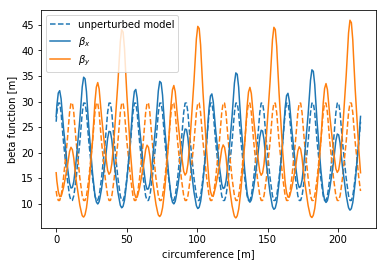

In [7]:
plt.plot(model_s, model_bx, '--', color='#1f77b4', label='unperturbed model')
plt.plot(model_s, model_by, '--', color='#ff7f0e')

plt.plot(perturbedModel_s, perturbedModel_bx, color='#1f77b4', label=r'$\beta_x$')
plt.plot(perturbedModel_s, perturbedModel_by, color='#ff7f0e', label=r'$\beta_y$')

plt.xlabel('circumference [m]')
plt.ylabel('beta function [m]')
plt.legend()

#plt.savefig('beta_function.pdf')


In [8]:
# train set
#A = 40
#from scipy import constants
#print(constants.value("proton mass energy equivalent in MeV"))

beam = Beam(mass=18.798, energy=100.0, exn=1.258e-6, eyn=2.005e-6, sigt=0.01, sige=0.000, particles=500)
bunch = beam.bunch[:].to(device)
label = perturbedModel(bunch, nTurns = 1, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)#, twiss = modelTwiss, index=s_index).to(device)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)


In [9]:
# before training
initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)
initialDiffNormal, initialDiffSkew = compareMultipoleStrengths(model, perturbedModel)
modelTwiss, perturbedTwiss = model.getTwiss(), perturbedModel.getTwiss()

In [10]:
# activate gradients on kick maps
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        element.k1n.requires_grad_(True)
        element.k2n.requires_grad_(True)
        
        # currently twiss parameters cannot be calculated for coupled motion
        element.k1s.requires_grad_(False)
        element.k2s.requires_grad_(False)

# set up optimizer
optimizer = optim.Adagrad(model.parameters())#, lr=9e-2)
criterion = nn.MSELoss()


In [ ]:
epochs = 100#0

# train loop
t0 = time.time()

loss_count = []
k_poch = list()
tune_x, tune_y = list(), list()

tmp = list()
for elementA, elementB in zip(model.elements,perturbedModel.elements):
    if type(elementA) is Elements.Quadrupole:
        tmp.append(elementA.k1n.item() - elementB.k1n.item())
k_poch.append(tmp)

tune_x.append(model.getTunes()[0])
tune_y.append(model.getTunes()[1])

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()
        
        out = model(bunch, nTurns = 1, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)#, twiss = modelTwiss, index=s_index)
        
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # only x-, y-plane
    
        loss.backward()
        optimizer.step()
        
   
    print(epoch, loss.item(), model.getTunes()[0], model.getTunes()[1])   
    
    tmp = list()
    for elementA, elementB in zip(model.elements,perturbedModel.elements) :
            if type(elementA) is Elements.Quadrupole:
                tmp.append(elementA.k1n.item() - elementB.k1n.item())
    
    k_poch.append(tmp)
    tune_x.append(model.getTunes()[0])
    tune_y.append(model.getTunes()[1])
    loss_count.append(loss.item())
    if loss.item() < 9e-23:
        break

print("training completed within {:.2f}s".format(time.time() - t0))

#with open('test.json', 'w') as json_file:
#    json.dump([], json_file)
    

# after training

finalTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)
finalDiffNormal, finalDiffSkew = compareMultipoleStrengths(model, perturbedModel)
finalModelTwiss = model.getTwiss()    

# save data
basicList = [initialTrajectoriesDifference, finalTrajectoriesDifference, 
            initialDiffNormal, initialDiffSkew, modelTwiss, perturbedTwiss, finalModelTwiss,
            finalDiffNormal, finalDiffSkew, k_poch, loss_count, tune_x, tune_y, perturbedModel.getTunes()[0], perturbedModel.getTunes()[1], lattice_model, lattice_perturbedModel, time.time() - t0]

torch.save(basicList, 'test.pt')

0 1.2971240044966124e-15 0.04994112573675525 nan
1 1.2743610681176413e-15 0.04794422117477184 nan
2 1.1064013862468583e-15 0.046216774477429896 nan
3 1.1104219535044955e-15 0.044811977390020276 nan
4 8.108509221144076e-16 0.04355448074238654 nan
5 7.895934845703243e-16 0.04203035828618138 nan
